### Este projeto tem como foco a Classificação de amostras geológicas por meio de imagens por meio de imagens utilizando o modelo InceptionV3. O objetivo principal é avaliar a eficácia e precisão da rede neural pré-treinada na identificação de diferentes tipos de estruturas contidas em rochas. Esse estudo busca auxiliar profissionais no reconhecimento de estruturas geológicas assim como tambémfornecer conclusões relevantes sobre a aplicação de inteligência artificial em geologia e ciências da terra.

In [30]:
# Importações de libs necessárias

import os
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from keras import regularizers

from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from PIL import Image

In [2]:
# Definir caminhos dos diretórios de treino, validação e teste
diretorio_treino = 'D:/Pessoal/Estudos_Pessoais/Pos_Graduacao/Clone_GitHub/Sprint_2/Deep_Learning/Geological_Structures/Classes_Structures/Train/'
diretorio_validacao = 'D:/Pessoal/Estudos_Pessoais/Pos_Graduacao/Clone_GitHub/Sprint_2/Deep_Learning/Geological_Structures/Classes_Structures/Validation/'
diretorio_teste = 'D:/Pessoal/Estudos_Pessoais/Pos_Graduacao/Clone_GitHub/Sprint_2/Deep_Learning/Geological_Structures/Classes_Structures/Test/'

In [3]:
# Definir o tamanho das imagens e o número de classes
input_shape = (256, 256, 3)
num_classes = 9

In [4]:
# Definir os hiperparâmetros do treinamento
batch_size = 128
epochs = 100

##### Nesse passo será usado o 'ImageDataGenerator' que é uma classe da biblioteca Keras que permite gerar lotes de imagens aumentadas (augmented images) em tempo real durante o treinamento de modelos de aprendizado profundo.
##### O objetivo principal do 'ImageDataGenerator' é aumentar a quantidade de dados de treinamento disponíveis, melhorando a capacidade de generalização do modelo e reduzindo o risco de overfitting. O aumento de dados envolve a aplicação de transformações aleatórias nas imagens existentes, como rotação, translação, zoom, espelhamento horizontal, alteração de brilho, entre outras técnicas. 

In [5]:
# Definir o data augmentation para imagens de treinamento
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Usar o ImageDataGenerator normal (sem data augmentation) para imagens de validação e teste
validation_datagen = ImageDataGenerator(rescale=1.0/255)

test_datagen = ImageDataGenerator(rescale=1.0/255)


In [6]:
# Definir o gerador de dados para as imagens de treinamento
train_generator = train_datagen.flow_from_directory(
    diretorio_treino,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    diretorio_validacao,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    diretorio_teste,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1310 images belonging to 9 classes.
Found 360 images belonging to 9 classes.
Found 135 images belonging to 9 classes.


### Vou fazer o treinamento com 3 modelos, a CNN simples, Resnet50 e InceptionV3. O modelo como melhor resultado de acurácia será usado para classificar as imagens de teste.

### Modelo CNN Profunda

In [19]:
# Carregar o modelo CNN Profunda e adicionar as camadas personalizadas

cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(input_shape)))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu',))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(128, (3, 3), activation='relu',))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(256, (3, 3), activation='relu',))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu',))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(32, activation='relu',))
tf.keras.layers.Dropout(0.25),
cnn_model.add(Dense(num_classes, activation='softmax'))

In [20]:
# Compilar o modelo CNN com o otimizador Adam configurado com a taxa de aprendizado
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Exibir o resumo do modelo
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 128)     

In [21]:
# Criar o callback para visualização das imagens durante o treinamento
tensorboard_callback = TensorBoard(log_dir='./logs')

In [22]:
es = EarlyStopping(patience=4)
rlr = ReduceLROnPlateau(monitor='val_loss', patience=4)
mc = ModelCheckpoint(filepath='best_{epoch:03d}-{val_loss:.4f}.h5', save_best_only=True) 

In [23]:
# Treinar o modelo CNN apenas com os dados de treino
history_cnn = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[tensorboard_callback]
)

Epoch 1/100
10/10 [==============================] - 9s 868ms/step - loss: 2.2104 - accuracy: 0.0948 - val_loss: 2.1967 - val_accuracy: 0.1602
Epoch 2/100
10/10 [==============================] - 8s 801ms/step - loss: 2.1954 - accuracy: 0.1142 - val_loss: 2.1904 - val_accuracy: 0.1875
Epoch 3/100
10/10 [==============================] - 8s 787ms/step - loss: 2.1643 - accuracy: 0.1616 - val_loss: 2.1724 - val_accuracy: 0.1602
Epoch 4/100
10/10 [==============================] - 8s 782ms/step - loss: 2.1247 - accuracy: 0.1582 - val_loss: 2.1334 - val_accuracy: 0.1914
Epoch 5/100
10/10 [==============================] - 8s 784ms/step - loss: 2.0639 - accuracy: 0.1819 - val_loss: 2.0169 - val_accuracy: 0.2344
Epoch 6/100
10/10 [==============================] - 9s 844ms/step - loss: 2.0291 - accuracy: 0.1781 - val_loss: 1.9876 - val_accuracy: 0.1953
Epoch 7/100
10/10 [==============================] - 8s 787ms/step - loss: 1.9930 - accuracy: 0.2064 - val_loss: 2.0923 - val_accuracy: 0.2617

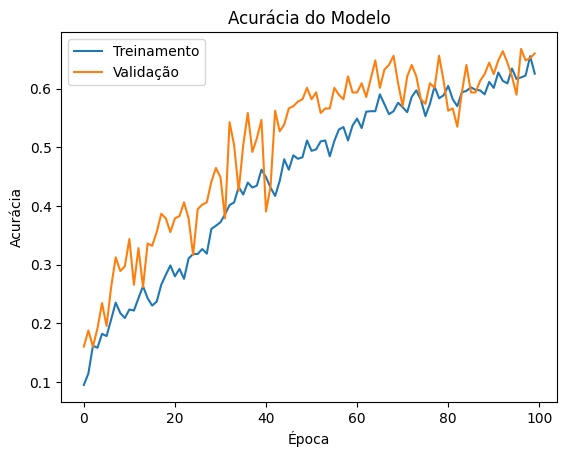

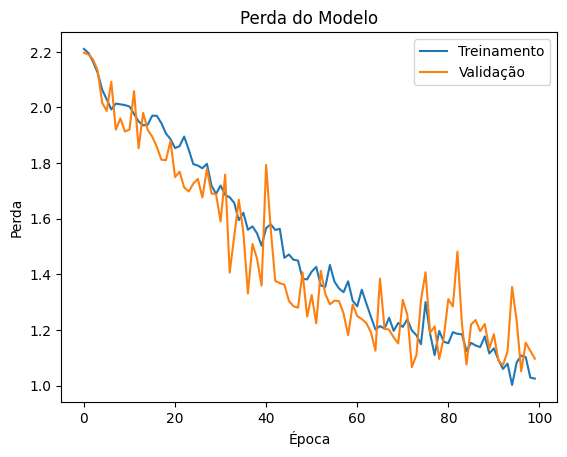

In [28]:
# Plotar a acurácia e a perda durante o treinamento
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.show()

plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend(['Treinamento', 'Validação'], loc='upper right')
plt.show()

In [29]:
# Avaliar o modelo no conjunto de teste
test_loss, test_accuracy = cnn_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Acurácia no conjunto de teste:', test_accuracy)

1/1 [==============================] - 0s 492ms/step - loss: 1.0084 - accuracy: 0.6406
Acurácia no conjunto de teste: 0.640625


Falar sobre esse resultado....

### Modelo Resnet50
Discorrer um pouco sobre as vantagens de usar cada modelo.

In [31]:
# Carregue o modelo ResNet50 pré-treinado (sem incluir as camadas totalmente conectadas no topo)
Resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Congele as camadas do modelo base para que elas não sejam treinadas novamente
Resnet_model.trainable = False

In [33]:
# Crie o modelo final, adicionando camadas personalizadas no topo do modelo base
Resnet_model = tf.keras.models.Sequential([
    Resnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [34]:
# Compile o modelo
Resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Exibir o resumo do modelo
Resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                      

In [35]:
# Criar o callback para visualização das imagens durante o treinamento
tensorboard_callback = TensorBoard(log_dir='./logs')

In [36]:
# Treinar o modelo e armazenar o histórico
history_Resnet50 = Resnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[tensorboard_callback]
)

Epoch 1/100
10/10 [==============================] - 12s 937ms/step - loss: 2.2365 - accuracy: 0.1379 - val_loss: 2.1838 - val_accuracy: 0.0859
Epoch 2/100
10/10 [==============================] - 9s 838ms/step - loss: 2.2029 - accuracy: 0.1100 - val_loss: 2.1615 - val_accuracy: 0.1172
Epoch 3/100
10/10 [==============================] - 9s 849ms/step - loss: 2.1695 - accuracy: 0.1565 - val_loss: 2.1247 - val_accuracy: 0.1250
Epoch 4/100
10/10 [==============================] - 9s 901ms/step - loss: 2.1568 - accuracy: 0.1758 - val_loss: 2.0688 - val_accuracy: 0.1875
Epoch 5/100
10/10 [==============================] - 9s 936ms/step - loss: 2.1369 - accuracy: 0.1599 - val_loss: 2.0291 - val_accuracy: 0.2930
Epoch 6/100
10/10 [==============================] - 9s 843ms/step - loss: 2.1116 - accuracy: 0.1929 - val_loss: 2.0628 - val_accuracy: 0.1172
Epoch 7/100
10/10 [==============================] - 9s 923ms/step - loss: 2.1153 - accuracy: 0.1656 - val_loss: 2.0162 - val_accuracy: 0.289

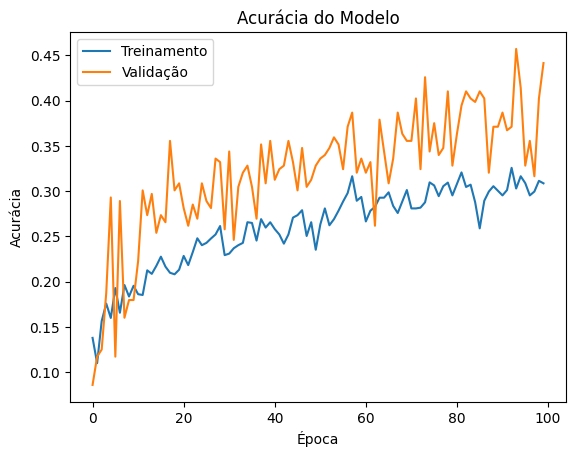

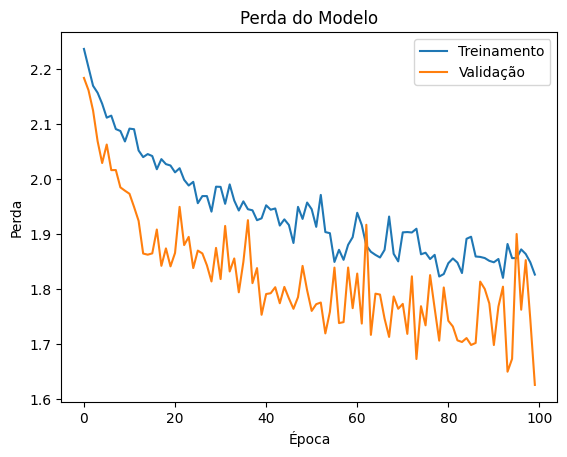

In [37]:
# Plotar a acurácia e a perda durante o treinamento
plt.plot(history_Resnet50.history['accuracy'])
plt.plot(history_Resnet50.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.show()

plt.plot(history_Resnet50.history['loss'])
plt.plot(history_Resnet50.history['val_loss'])
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend(['Treinamento', 'Validação'], loc='upper right')
plt.show()

In [38]:
# Avaliar o modelo no conjunto de teste
test_loss, test_accuracy = Resnet_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Acurácia no conjunto de teste:', test_accuracy)

1/1 [==============================] - 1s 674ms/step - loss: 1.7279 - accuracy: 0.3281
Acurácia no conjunto de teste: 0.328125


Falar sobre esse resultado....

### Modelo InceptionV3
Discorrer um pouco sobre as vantagens de usar cada modelo.

##### Foi adicionada uma camada de 1024 neurônios, diminuuindo até chegar próximo ao número de saída, todas Dense, e uma camada de saida Danse de 9 neurônios representando cada uma das classes de estruturas. Foi estabelecido um fator de aprendizagem de 0.001, bem como a função de reativação 'relu' no final de cada camada intermediária.  Foi usado o Dropout também, que é uma técnica eficaz para combater o overfitting, fornecendo uma regularização interna durante o treinamento da rede neural. E para finalizar  as camadas, foi usado a função de reativação 'softmax', pois esse estudo se trata de uma classificação multiclasse.

In [95]:
# Carregar o modelo InceptionV3 pré-treinado, usando os pesos da Imagenet e informado o tamanho das imagens.
Inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Congelar todas as camadas do modelo base
for layer in Inception_model.layers:
    layer.trainable = False

In [96]:
# Crie o modelo final, adicionando camadas personalizadas no topo do modelo base
Inception_model = tf.keras.models.Sequential([
    Inception_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [97]:
# Compilar o modelo
Inception_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Exibir o resumo do modelo
Inception_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_8   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_54 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_55 (Dense)            (None, 512)               524800    
                                                                 
 dense_56 (Dense)            (None, 256)               131328    
                                                                 
 dense_57 (Dense)            (None, 128)               32896     
                                                     

In [98]:
# Criar o callback para visualização das imagens durante o treinamento
tensorboard_callback = TensorBoard(log_dir='./logs')

In [99]:
es = EarlyStopping(patience=4)
rlr = ReduceLROnPlateau(monitor='val_loss', patience=4)
mc = ModelCheckpoint(filepath='best_{epoch:03d}-{val_loss:.4f}.h5', save_best_only=True) 

#### Após a configuração da rede, é possível realizar o treinamento utilizando o conjunto de dados de amostras geológicas. Durante o treinamento, é importante monitorar as métricas de desempenho da rede, como acurácia e perda. Para isto, foram usados os callbacks EarlyStopping e ReduceLROnPlateau para interromper o treinamento no momento de ter ganhos não significativos junto com o ModelCheckpoint que permite salvar o modelo com melhor eficiência.

In [100]:
# Treinar o modelo e armazenar o histórico
history_Inception = Inception_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[tensorboard_callback]
)

Epoch 1/100
10/10 [==============================] - 12s 926ms/step - loss: 2.2532 - accuracy: 0.1379 - val_loss: 2.1452 - val_accuracy: 0.1758
Epoch 2/100
10/10 [==============================] - 8s 791ms/step - loss: 2.1431 - accuracy: 0.1497 - val_loss: 1.9930 - val_accuracy: 0.2266
Epoch 3/100
10/10 [==============================] - 8s 808ms/step - loss: 2.0430 - accuracy: 0.2191 - val_loss: 1.8177 - val_accuracy: 0.4336
Epoch 4/100
10/10 [==============================] - 8s 831ms/step - loss: 1.8244 - accuracy: 0.3266 - val_loss: 1.4786 - val_accuracy: 0.5234
Epoch 5/100
10/10 [==============================] - 8s 815ms/step - loss: 1.7090 - accuracy: 0.4019 - val_loss: 1.3399 - val_accuracy: 0.6133
Epoch 6/100
10/10 [==============================] - 8s 831ms/step - loss: 1.5079 - accuracy: 0.4890 - val_loss: 1.1039 - val_accuracy: 0.6328
Epoch 7/100
10/10 [==============================] - 9s 839ms/step - loss: 1.4186 - accuracy: 0.5102 - val_loss: 1.0561 - val_accuracy: 0.679

In [102]:
# Avaliar o modelo no conjunto de teste
test_loss, test_accuracy = Inception_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Acurácia no conjunto de teste:', test_accuracy)

1/1 [==============================] - 0s 433ms/step - loss: 0.3770 - accuracy: 0.9062
Acurácia no conjunto de teste: 0.90625


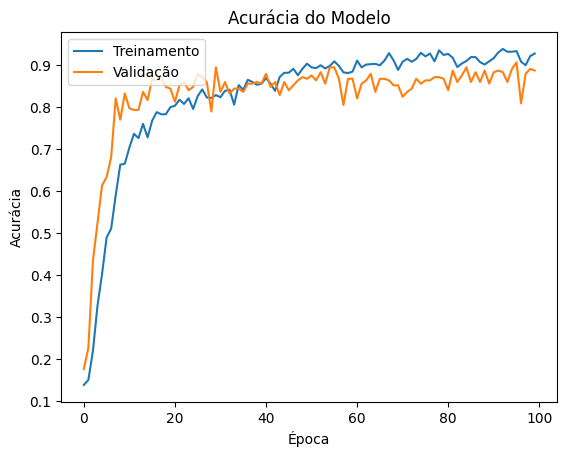

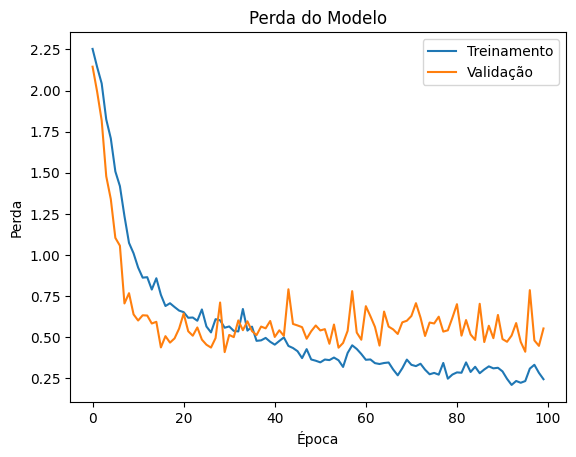

In [103]:
# Plotar a acurácia e a perda durante o treinamento
plt.plot(history_Inception.history['accuracy'])
plt.plot(history_Inception.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.show()

plt.plot(history_Inception.history['loss'])
plt.plot(history_Inception.history['val_loss'])
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend(['Treinamento', 'Validação'], loc='upper right')
plt.show()

In [ ]:
# Salvar o modelo InceptionV3
model.save('D:/Pessoal/Estudos_Pessoais/Pos_Graduacao/Clone_GitHub/Sprint_2/Deep_Learning/Geological_Structures/Models_Train/MVP_Sprint2.h5')

4/4 [==============================] - 1s 39ms/step


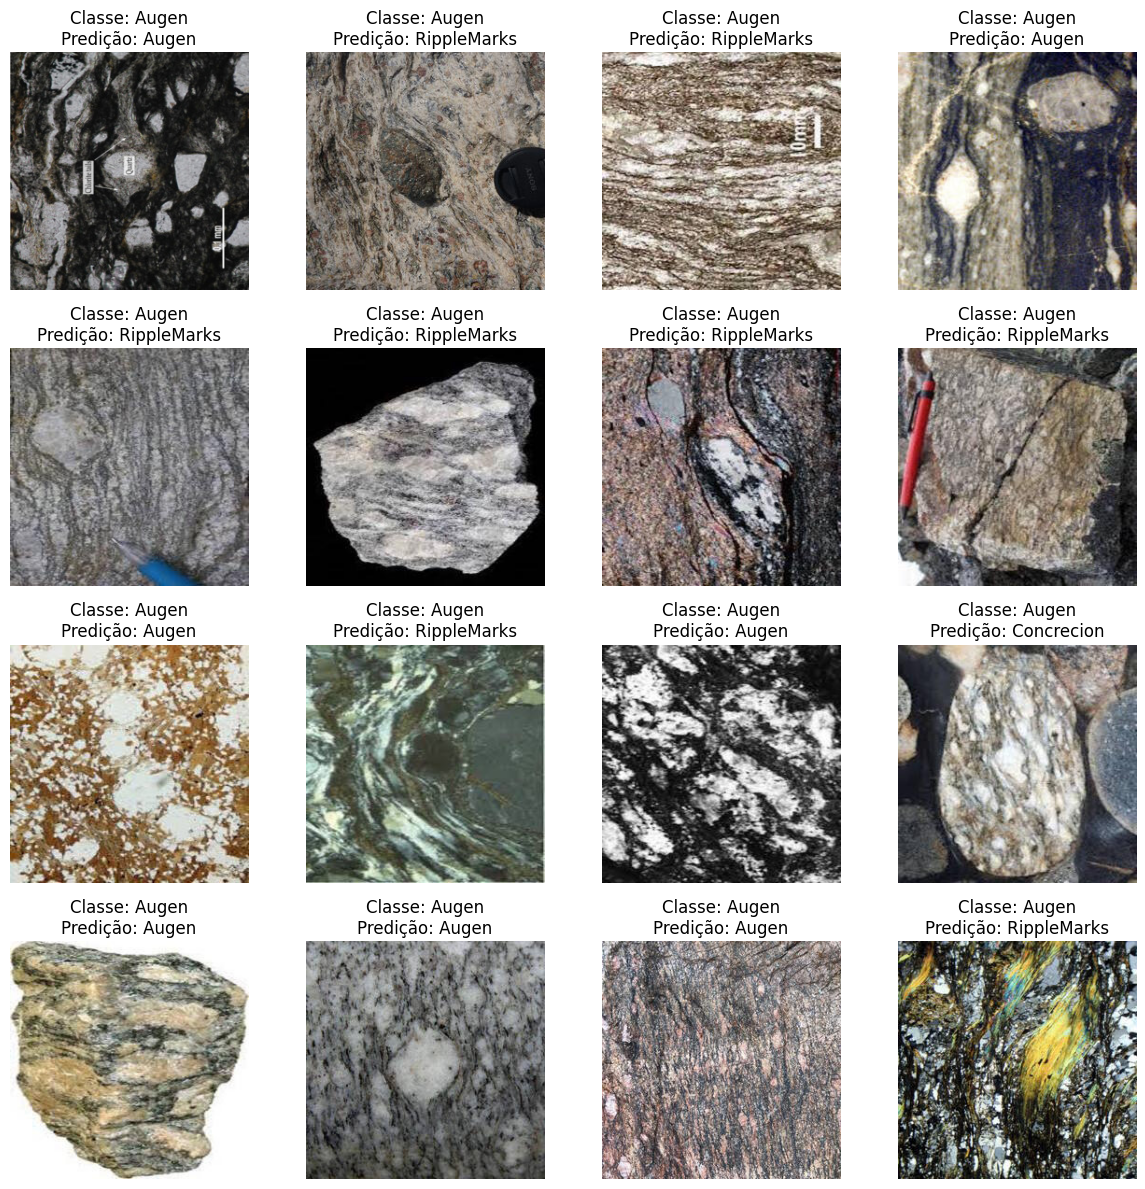

In [104]:
# Visualizar algumas imagens do conjunto de validação e suas classes
class_names = sorted(validation_generator.class_indices.keys())
images, labels = next(validation_generator)
predicted_labels = model.predict(images)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img = images[i]
    label = np.argmax(labels[i])
    predicted_label = np.argmax(predicted_labels[i])
    
    ax.imshow(img)
    ax.set_title(f'Classe: {class_names[label]}\nPredição: {class_names[predicted_label]}')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [105]:
# Fazer previsões nas imagens de teste
predictions = Inception_model.predict(test_generator)

# Obter as classes preditas para cada imagem
predicted_classes = np.argmax(predictions, axis=1)

# Obter as classes reais para cada imagem
true_classes = test_generator.classes

# Obter os rótulos das classes
class_labels = list(test_generator.class_indices.keys())

2/2 [==============================] - 1s 387ms/step


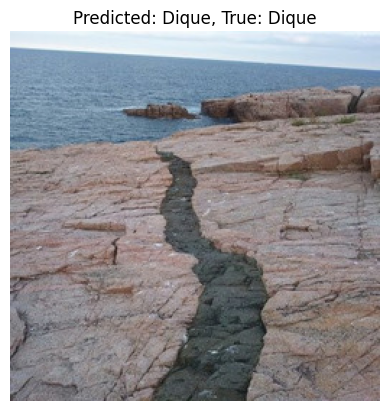

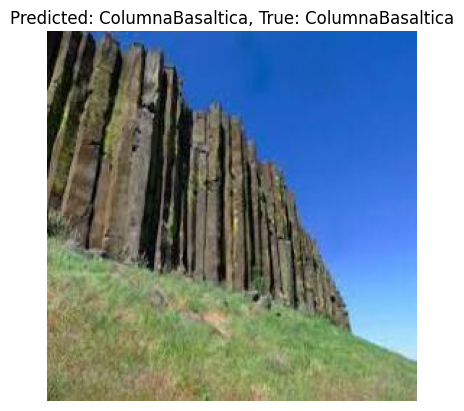

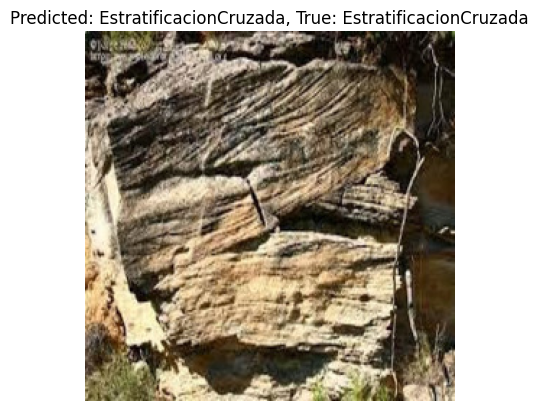

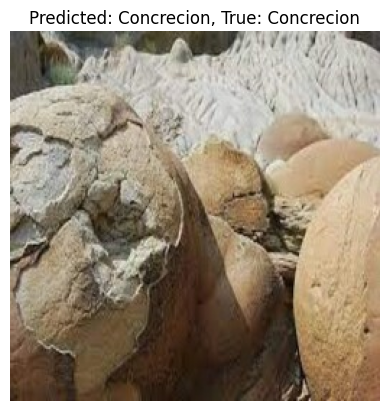

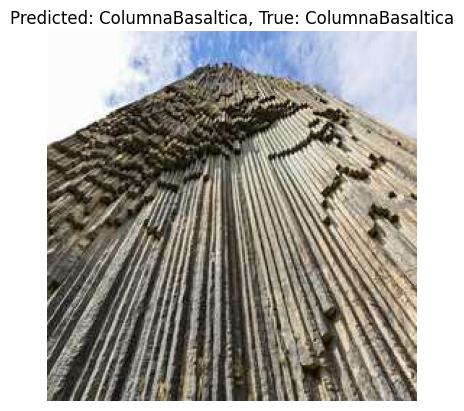

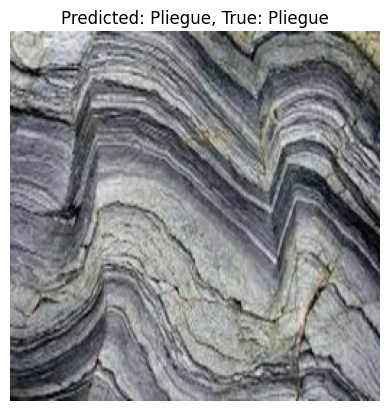

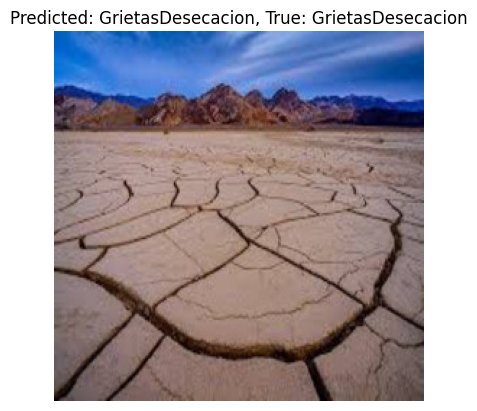

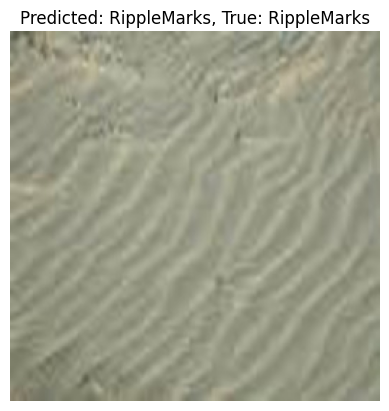

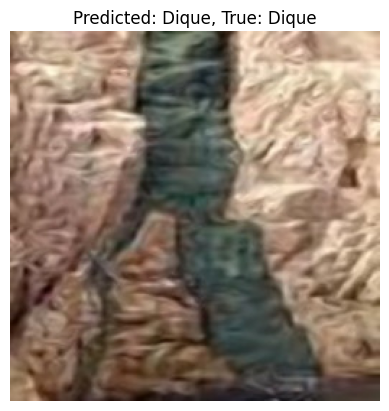

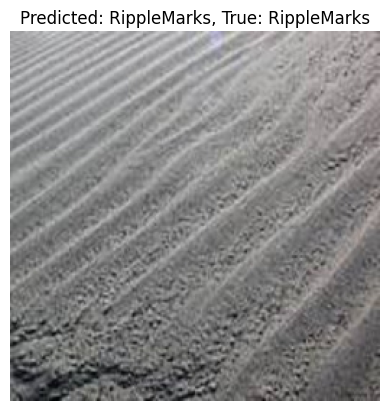

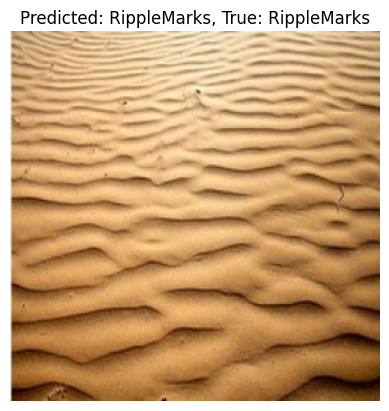

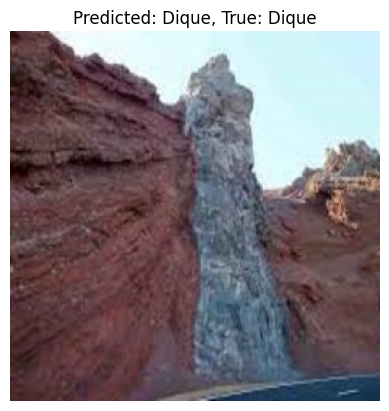

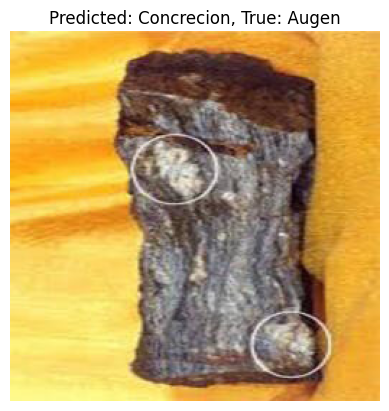

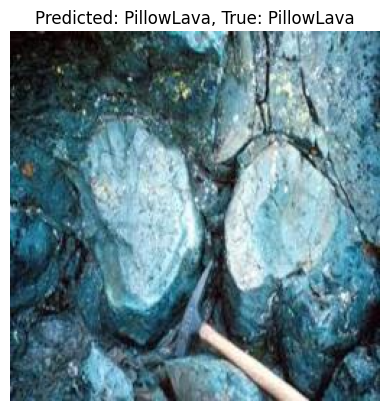

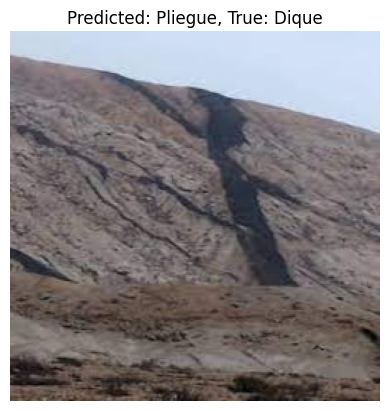

In [106]:
# Mostrar algumas imagens de teste com suas classes preditas e reais
num_images = 15  # Número de imagens para mostrar
sample_indices = np.random.choice(len(test_generator.filenames), num_images, replace=False)
for idx in sample_indices:
    image_path = os.path.join(diretorio_teste, test_generator.filenames[idx])
    image = Image.open(image_path)
    predicted_class = class_labels[predicted_classes[idx]]
    true_class = class_labels[true_classes[idx]]
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}, True: {true_class}')
    plt.axis('off')
    plt.show()